# Pre-processing of avalanche warning data for machine learning


In [1]:
import pandas as pd
import numpy as np
import json
#import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style="white")
#from sklearn import tree
#from sklearn.preprocessing import LabelEncoder
#from pprint import pprint

#pd.set_option("display.max_rows",6)

%matplotlib inline

In [3]:
# analysis of entire data set
varsom_df = pd.read_csv(r'..\..\data\varsom\norwegian_avalanche_warnings_season_17_18.csv', index_col=0)
varsom_df.head()

,author,avalanche_danger,avalanche_problem_1_advice,avalanche_problem_1_cause_id,avalanche_problem_1_cause_name,avalanche_problem_1_destructive_size_ext_id,avalanche_problem_1_destructive_size_ext_name,avalanche_problem_1_distribution_id,avalanche_problem_1_distribution_name,avalanche_problem_1_exposed_height_1,...,region_id,region_name,region_type_id,region_type_name,snow_surface,utm_east,utm_north,utm_zone,valid_from,valid_to
index,,,,,,,,,,,,,,,,,,,,,
0,Karsten@NVE,Det er lite snø og generelt stabile forhold i ...,Vær varsom der skredproblemet er å finne i ko...,15,Dårlig binding mellom lag i fokksnøen,2,2 - Middels,1,Få bratte heng,0,...,3003,Nordenskiöld Land,10,A,Det er generelt lite snø i terrenget. Rygger e...,520332,8663904,33,2017-12-01 00:00:00,2017-12-01 23:59:59
1,jan arild@obskorps,Kraftig vind fra sørøst vil gi pålagring av fe...,Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,...,3007,Vest-Finnmark,10,A,Siste dagene har det kommet 25-30 cm snø utsat...,802123,7794717,33,2017-12-01 00:00:00,2017-12-01 23:59:59
2,jan arild@obskorps,"Generelle stabile forhold, men vindøkning fra ...",Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,...,3009,Nord-Troms,10,A,Siste dagene har det kommet 20-30 cm snø utsat...,750984,7742562,33,2017-12-01 00:00:00,2017-12-01 23:59:59
3,jan arild@obskorps,Vindøkning fra sør vil gi pålagring av fersk f...,Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,...,3010,Lyngen,10,A,Siste dagene har det kommet 10-20 cm snø utsat...,692056,7719872,33,2017-12-01 00:00:00,2017-12-01 23:59:59
4,jan arild@obskorps,Kraftig vind fra sør vil gi pålagring av fersk...,Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,...,3011,Tromsø,10,A,Siste dagene har det kommet 25-40 cm snø utsat...,656496,7764237,33,2017-12-01 00:00:00,2017-12-01 23:59:59


Check if there are missing values.

In [4]:
# Find the amount of NaN values in each column
print(varsom_df.isnull().sum().sort_values(ascending=False))

mountain_weather_change_wind_direction           2509
mountain_weather_change_hour_of_day_start        2491
mountain_weather_change_hour_of_day_stop         2491
mountain_weather_change_wind_speed               2483
mountain_weather_fl_hour_of_day_stop             1543
mountain_weather_fl_hour_of_day_start            1543
latest_observations                              1161
latest_avalanche_activity                         821
mountain_weather_freezing_level                   417
current_weak_layers                               247
mountain_weather_wind_direction                    74
mountain_weather_temperature_max                   45
mountain_weather_temperature_min                   44
mountain_weather_temperature_elevation             30
mountain_weather_precip_most_exposed                6
mountain_weather_precip_region                      4
avalanche_problem_2_advice                          2
avalanche_problem_1_advice                          2
mountain_weather_wind_speed 

Fill missing values where necessary.

In [5]:
varsom_df['mountain_weather_wind_speed'] = varsom_df['mountain_weather_wind_speed'].fillna('None')
varsom_df['mountain_weather_wind_direction'] = varsom_df['mountain_weather_wind_direction'].fillna('None')
print(varsom_df.isnull().sum().sort_values(ascending=False))

mountain_weather_change_wind_direction           2509
mountain_weather_change_hour_of_day_stop         2491
mountain_weather_change_hour_of_day_start        2491
mountain_weather_change_wind_speed               2483
mountain_weather_fl_hour_of_day_start            1543
mountain_weather_fl_hour_of_day_stop             1543
latest_observations                              1161
latest_avalanche_activity                         821
mountain_weather_freezing_level                   417
current_weak_layers                               247
mountain_weather_temperature_max                   45
mountain_weather_temperature_min                   44
mountain_weather_temperature_elevation             30
mountain_weather_precip_most_exposed                6
mountain_weather_precip_region                      4
avalanche_problem_2_advice                          2
avalanche_problem_1_advice                          2
avalanche_problem_2_distribution_id                 0
avalanche_problem_2_destruct

## Feature engineering
Re-label og -classifiy variables where necessary.

In [6]:
from regroup_forecast import regroup

varsom_df = regroup(varsom_df)

Hot encode categorial varaiables where necessary.

In [7]:
# hot encode
hot_encode_ = ['emergency_warning', 'author', 'mountain_weather_wind_direction']
pd.get_dummies(varsom_df, columns=hot_encode_)

,avalanche_danger,avalanche_problem_1_advice,avalanche_problem_1_cause_id,avalanche_problem_1_cause_name,avalanche_problem_1_destructive_size_ext_id,avalanche_problem_1_destructive_size_ext_name,avalanche_problem_1_distribution_id,avalanche_problem_1_distribution_name,avalanche_problem_1_exposed_height_1,avalanche_problem_1_exposed_height_2,...,author_torolav@obskorps,mountain_weather_wind_direction_E,mountain_weather_wind_direction_N,mountain_weather_wind_direction_NE,mountain_weather_wind_direction_NW,mountain_weather_wind_direction_None,mountain_weather_wind_direction_S,mountain_weather_wind_direction_SE,mountain_weather_wind_direction_SW,mountain_weather_wind_direction_W
index,,,,,,,,,,,,,,,,,,,,,
0,Det er lite snø og generelt stabile forhold i ...,Vær varsom der skredproblemet er å finne i ko...,15,Dårlig binding mellom lag i fokksnøen,2,2 - Middels,1,Få bratte heng,0,0,...,0,0,1,0,0,0,0,0,0,0
1,Kraftig vind fra sørøst vil gi pålagring av fe...,Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,0,...,0,0,0,0,0,0,0,1,0,0
2,"Generelle stabile forhold, men vindøkning fra ...",Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,0,...,0,0,0,0,0,0,0,1,0,0
3,Vindøkning fra sør vil gi pålagring av fersk f...,Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,0,...,0,0,0,0,0,0,1,0,0,0
4,Kraftig vind fra sør vil gi pålagring av fersk...,Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,0,...,0,0,0,0,0,0,1,0,0,0
5,Kraftig vind fra sør vil gi pålagring av fersk...,Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,0,...,0,0,0,0,0,0,1,0,0,0
6,Generelle stabile forhold. Fokksnø trenger for...,Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,0,...,0,0,0,0,0,0,1,0,0,0
7,Kraftig vind vil frakte den løse snøen inn i l...,Vær forsiktig i områder brattere enn 30 grader...,10,Nedføyket svakt lag med nysnø,2,2 - Middels,2,Noen bratte heng,400,0,...,0,0,0,0,0,0,0,0,1,0
8,Generelle stabile forhold og tynt snødekke. Kr...,Hold god avstand til hverandre ved ferdsel i s...,19,Kantkornet snø under skarelag,2,2 - Middels,2,Noen bratte heng,700,0,...,0,0,0,0,0,0,1,0,0,0


Eventually remove variables with many missing values.

In [8]:
del_list = [
    'mountain_weather_change_wind_direction',
    'mountain_weather_change_hour_of_day_start',
    'mountain_weather_change_hour_of_day_stop',
    'mountain_weather_change_wind_speed',
    'mountain_weather_fl_hour_of_day_stop',
    'mountain_weather_fl_hour_of_day_start',
    'latest_observations'
]
removed_ = [varsom_df.pop(v) for v in del_list]

Remove variables we know we do not need. In this case mainly because they are redundant like the _avalanche\_problem\_1\_ext\_name_ and _avalanche\_problem\_1\_ext\_id_ - in this case we only keep the numeric _id_ variable.

In [9]:
del_list = [
    'utm_zone',
    'utm_east',
    'utm_north',
    'danger_level_name',
    'avalanche_problem_1_exposed_height_fill',
    'avalanche_problem_2_exposed_height_fill',
    'avalanche_problem_3_exposed_height_fill',
    'avalanche_problem_1_valid_expositions',
    'avalanche_problem_2_valid_expositions',
    'avalanche_problem_3_valid_expositions',
    'avalanche_problem_1_cause_name',
    'avalanche_problem_1_destructive_size_ext_name',
    'avalanche_problem_1_distribution_name',
    'avalanche_problem_1_ext_name',
    'avalanche_problem_1_probability_name',
    'avalanche_problem_1_trigger_simple_name',
    'avalanche_problem_1_type_name',
    'avalanche_problem_2_cause_name',
    'avalanche_problem_2_destructive_size_ext_name',
    'avalanche_problem_2_distribution_name',
    'avalanche_problem_2_ext_name',
    'avalanche_problem_2_probability_name',
    'avalanche_problem_2_trigger_simple_name',
    'avalanche_problem_2_type_name',
    'avalanche_problem_3_cause_name',
    'avalanche_problem_3_destructive_size_ext_name',
    'avalanche_problem_3_distribution_name',
    'avalanche_problem_3_ext_name',
    'avalanche_problem_3_probability_name',
    'avalanche_problem_3_trigger_simple_name',
    'avalanche_problem_3_type_name',
    'latest_avalanche_activity',
    'main_text',
    'snow_surface',
    'current_weak_layers',
    'avalanche_danger',
    'avalanche_problem_1_advice',
    'avalanche_problem_2_advice',
    'avalanche_problem_3_advice',
    'mountain_weather_wind_speed',
    'mountain_weather_wind_direction',
    'emergency_warning',
    'region_name',
    'reg_id',
    'valid_from',
    'valid_to'
]
removed_ = [varsom_df.pop(v) for v in del_list]

In [10]:
# Check if there are no weired values.
for col in varsom_df.columns.values:
    print(f'{col}: {varsom_df[col].unique()} \n')

author: ['Karsten@NVE' 'jan arild@obskorps' 'Jørgen@obskorps' 'Espen Granan'
 'HåvardT@met' 'JonasD@ObsKorps' 'torolav@obskorps' 'siri@met'
 'Halvor@NVE' 'Silje@svv' 'John Smits' 'jostein@nve' 'anitaaw@met'
 'haso@nve.no' 'Andreas@nve' 'ragnhildn@met' 'ToreV@met' 'Ragnar@NVE'
 'Ida@met' 'MSA@nortind' 'hrb@nve.no' 'EspenN' 'Ronny@NVE' 'rue@nve'
 'knutinge@svv' 'Ingrid@NVE' 'jegu@NVE' 'torehum@svv' 'Tommy@NVE'
 'martin@svv' 'emma@nve'] 

avalanche_problem_1_cause_id: [15 10 19 11 22 18 16 20 14 24 13  0] 

avalanche_problem_1_destructive_size_ext_id: [2 1 3 0 4] 

avalanche_problem_1_distribution_id: [1 2 3 0] 

avalanche_problem_1_exposed_height_1: [   0  400  700  800  600 1000  500 1200  300  200  900 1100 1400 1300
 1500  100 2000 1900 1700 1600 2100] 

avalanche_problem_1_exposed_height_2: [   0  400 1400  200  500  700  100 1000  800  300  600  900 1100 2000
 1200 1900] 

avalanche_problem_1_ext_id: [20 25  0 10 15] 

avalanche_problem_1_probability_id: [3 5 2 0] 

avalanche_proble

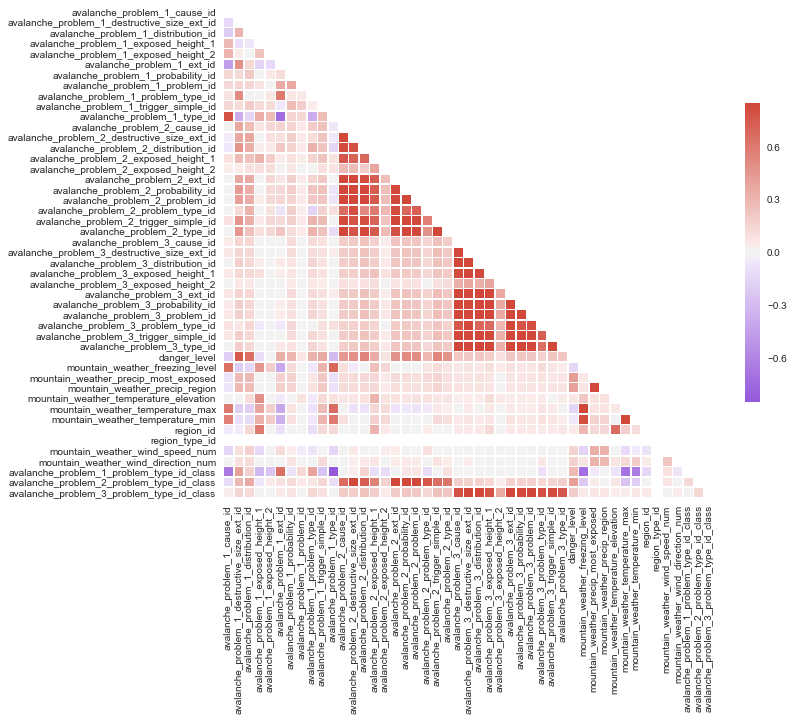

In [11]:
# Compute the correlation matrix - works only on numerical variables.
corr = varsom_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(1000, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We can see that some parameters are highly correlated. These are mainly the parameters belonging to the same avalanche problem. Depending on the ML algorithm we use we have to remove some of them.

In [12]:
#corr['avalanche_problem_1_cause_id'].sort_values(ascending=False)
#corr

In [15]:
#sns.pairplot(varsom_df.drop(['date_valid'], axis=1))

In [17]:
# let's see the details about remainig variables 

varsom_df.describe()

,avalanche_problem_1_cause_id,avalanche_problem_1_destructive_size_ext_id,avalanche_problem_1_distribution_id,avalanche_problem_1_exposed_height_1,avalanche_problem_1_exposed_height_2,avalanche_problem_1_ext_id,avalanche_problem_1_probability_id,avalanche_problem_1_problem_id,avalanche_problem_1_problem_type_id,avalanche_problem_1_trigger_simple_id,...,mountain_weather_temperature_elevation,mountain_weather_temperature_max,mountain_weather_temperature_min,region_id,region_type_id,mountain_weather_wind_speed_num,mountain_weather_wind_direction_num,avalanche_problem_1_problem_type_id_class,avalanche_problem_2_problem_type_id_class,avalanche_problem_3_problem_type_id_class
count,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000,...,3792.000000,3777.000000,3778.000000,3822.000000,3822.0,3822.000000,3822.000000,3822.000000,3822.000000,3822.000000
mean,14.857928,2.159864,1.805338,617.870225,62.611198,19.344584,3.019885,0.997907,14.845631,18.843276,...,1247.151899,-2.798809,-10.172578,3019.619048,10.0,4.947671,4.713239,5.274725,3.193354,0.356096
std,5.313807,0.671965,0.565790,355.952656,197.157994,2.513152,0.376101,0.045709,11.530338,4.701593,...,283.368795,6.540096,6.918327,9.424993,0.0,1.380078,1.839668,1.704677,3.058708,1.385644
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,500.000000,-22.000000,-32.000000,3003.000000,10.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,2.000000,1.000000,300.000000,0.000000,20.000000,3.000000,1.000000,7.000000,21.000000,...,1100.000000,-7.000000,-15.000000,3012.000000,10.0,4.000000,4.000000,5.000000,0.000000,0.000000
50%,13.000000,2.000000,2.000000,600.000000,0.000000,20.000000,3.000000,1.000000,10.000000,21.000000,...,1400.000000,-4.000000,-10.000000,3017.000000,10.0,5.000000,4.000000,6.000000,2.000000,0.000000
75%,19.000000,3.000000,2.000000,900.000000,0.000000,20.000000,3.000000,1.000000,30.000000,21.000000,...,1400.000000,0.000000,-5.000000,3028.000000,10.0,6.000000,6.000000,6.000000,7.000000,0.000000
max,24.000000,4.000000,3.000000,2100.000000,2000.000000,25.000000,5.000000,1.000000,50.000000,22.000000,...,1800.000000,20.000000,10.000000,3035.000000,10.0,10.000000,8.000000,7.000000,7.000000,7.000000


## Save data for further analysis

In [19]:
varsom_df.to_csv('varsom_ml_preproc.csv', index_label='index')

#### Now we have clean data and can build a model

The library we'll use is called **sckit-learn**. 

http://scikit-learn.org

- Python library
- Access to well known machine learning algorithms
- Built on NumPy, SciPy, and matplotlib
- Open Source
- Well documented with many good tutorials


## Worklflow of scikit-learn

- Create model object
- .fit
- .predict
- evaluate